# Intracellular Bio markers on Extracellular samples
Andrew E. Davidson   
aedavids@ucsc.edu   
1/17/24   

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref: testIntraCellularLungCancerBiomarkers.ipynb

Our goal is to see if the lung cancer biomarkers we found using our 1 vs. All deconvolution pipeline will work on extracelluar RNA plasma samples. testIntraCellularLungCancerBiomarkers.ipynb demonstrates the biomarkers work well on intracellular sample. ie GTEx and TCGA

This notebooks test to see if a model trainined on extracellular samples using the same genes works well

## Results
pipelineStageName = best10CuratedDegree1_ce467ff

GTEx_TCGA intracellular deconvolution results on training data set
```
sparcity = 72.45%
            Lung	LUAD	LUSC
sensitivity 0.994	0.841	0.691
specificity 0.998	0.998	0.995
```

Intracellular Bio markers on Extracellular training results
- 43 healthy donor plasma sample, 35 lung cancer plasma samples
- specificity = 0.86
- sensitivity = 0.6
- gene feature set sparcity = 26.57% of values are != 0
- one of the 30 biomarkers was missing from elife data set.
  * AC092140.2  ENSG00000274031.1  lncRNA

**comparison with training results using same genes on intracellular data**
ref: intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/testIntraCellularLungCancerBiomarkers.ipynb

- 341 healthy lung sample
- 610 lung cancer. (LUAD, LUSC)
- sensitivity = 0.994, specificity = 1.0

**<span style="background-color:yellow;color:red">TODO Go through scikit-plot and double check arguments</span>** 

[https://scikit-plot.readthedocs.io/en/stable/Quickstart.html](https://scikit-plot.readthedocs.io/en/stable/Quickstart.html)  
some plots pass y_test. it fit(train) then predict on a test set. some pass yTrue, ...

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)

import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

LOCAL_CACHE_DIR=f"/scratch/aedavids/tmp/"

outDir:
/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/img


In [2]:
import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    

In [3]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [4]:
# local imports
from analysis.signatureMatrixMetrics import checkForSparcity
from analysis.utilities import findSignatureGenesForPipelineStage #, loadDictionary, loadPipelineStageIntersectionDict
from confusion_matrix.cf_matrix import make_confusion_matrix
from intraExtraRNA.elifeUtilities import loadCounts, loadMetaData, selectFeatures
# from intraExtraRNA.mapIds import mapHUGO_2_ENSG
from intraExtraRNA.utilities import load, selectSamples

## Load elife data
The count data has been multiplied by the deseq estimated scaling factors. This normalizes data to account for differences in library size and composition

you can find additional meta data from GSE174302_meta.txt

In [5]:
countDF = loadCounts()
print( f'countDF.shape : {countDF.shape}')
display( countDF.head().iloc[0:4, 0:4] )

countDF.shape : (224, 76555)


gene,(A)n,(AAA)n,(AAAAAAC)n,(AAAAAAG)n
SRR14506659,201.672053,0.0,0.0,0.0
SRR14506660,110.450773,0.0,0.0,0.0
SRR14506661,3722.776395,0.0,0.0,0.0
SRR14506662,1394.605651,0.0,0.0,0.0


In [6]:
metaDF = loadMetaData()
print( f'metaDF.shape : {metaDF.shape}')
display(metaDF.head())
metaDF.groupby('diagnosis').count()

metaDF.shape : (224, 2)


,sample_id,diagnosis
0,SRR14506659,Esophagus Cancer
1,SRR14506660,Esophagus Cancer
2,SRR14506661,Esophagus Cancer
3,SRR14506662,Esophagus Cancer
4,SRR14506663,Esophagus Cancer


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36


## Select features

In [7]:
LUADGenes = findSignatureGenesForPipelineStage(category="LUAD", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'LUAD genes:\n{LUADGenes}')

LUSCGenes = findSignatureGenesForPipelineStage(category="LUSC", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\nLUSC genes:\n{LUSCGenes}')

# Lung is our healthy control
controlGenes = findSignatureGenesForPipelineStage(category="Lung", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\n healthy control Lung genes:\n{controlGenes}')

HUGO_lungGenes = LUADGenes + LUSCGenes + controlGenes
print(f'len(HUGO_lungGenes) {len(HUGO_lungGenes)}')

LUAD genes:
['AC011944.1', 'ATP13A4-AS1', 'AC090004.1', 'GXYLT1P3', 'AC126323.6', 'AC111149.2', 'AL365181.4', '(TCCAC)n', 'BPIFA2', 'IGHJ5']

LUSC genes:
['FMO6P', 'AC121493.1', 'AP001120.2', 'LINC01249', 'AP000344.1', '(TCTATG)n', 'AC092140.2', 'AP001360.1', 'ENPP7P11', 'AC018521.2']

 healthy control Lung genes:
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']
len(HUGO_lungGenes) 30


## map refSeq ids to ENSG
elife uses Ensembl gene ID


```
This does not work

v39Txt2GeneFilePath = "/private/groups/kimlab/genomes.annotations/genomes.annotations/gencode.39/gencode.v39.annotation.expanded.tx.to.gene.tsv"
v39GeneMapDF = mapHUGO_2_ENSG(v39Txt2GeneFilePath)
print(f'v39GeneMapDF.shape : {v39GeneMapDF.shape }')
display(v39GeneMapDF.head())'

file format has changed
head /private/groups/kimlab/genomes.annotations/genomes.annotations/gencode.39/gencode.v39.annotation.expanded.tx.to.gene.tsv
ENST00000456328.2	ENSG00000223972.5
ENST00000450305.2	ENSG00000223972.5
ENST00000473358.1	ENSG00000243485.5
ENST00000469289.1	ENSG00000243485.5
```

In [8]:
elifeLungGenes, missingElifeGenes = selectFeatures(countDF, HUGO_lungGenes)
print( f'len(elifeLungGenes) : {len(elifeLungGenes)}' )
print( f'missingElifeGenes\n : {missingElifeGenes}' )
# elifeLungGenes

refSeq2ENSGDF.loc[selectRows, :] :
              HUGO               ENSG bioType
97713   AC111149.2  ENSG00000253339.2  lncRNA
172016  AC092140.2  ENSG00000274031.1  lncRNA
203145      PCAT19  ENSG00000267107.8  lncRNA
len(elifeLungGenes) : 30
missingElifeGenes
 : ['ENSG00000274031.1']


# <span style="background-color:yellow;color:red">elife is missing some of our bio markers!</span>
for now just drop the missing gens

In [9]:
features = list( set(elifeLungGenes) - set(missingElifeGenes) )
assert len(features) == 29, "ERROR removing missing elife genes"

## create training data

In [10]:
# select training data
listOfCategories = ["Healthy donor", "Lung Cancer"]
tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
# display( tmpMetaDF.head() )
XDF = selectSamples(tmpMetaDF, countDF, listOfCategories)

XDF = XDF.loc[:, features]
print(f'XDF.shape : {XDF.shape}')

XDF.shape : (78, 29)


## check for sparcity

In [24]:
noZeroDF, rowSumDF, rowSumSummaryDF, geneCountSeries, sparcity = checkForSparcity(XDF, tmpMetaDF)
print(f'sparcity % values ! = 0 : {sparcity * 100}%')

print(f'\nrowSumSummaryDF\n')
display( rowSumSummaryDF )

print(f'\ngeneCountSeries: number of non zero values for each gene\n')
display( geneCountSeries )

print(f'\nrowSumDF: number of non zero values for each sample \n')
display(rowSumDF )

sparcity % values ! = 0 : 26.56940760389036%

rowSumSummaryDF



,mean,std,median
category,,,
Healthy donor,6.930233,2.955184,7.0
Lung Cancer,8.657143,4.465178,8.0



geneCountSeries: number of non zero values for each gene



gene
ENSG00000267143.1      2
ENSG00000108342.13    16
ENSG00000267107.9     69
ENSG00000131050.11     1
ENSG00000170175.11    65
ENSG00000270059.1      1
ENSG00000227755.1      3
ENSG00000054179.12    16
ENSG00000268279.4      2
ENSG00000261296.1     11
ENSG00000177699.4     12
ENSG00000264019.1      6
(TCCAC)n              30
ENSG00000242472.1      0
ENSG00000158714.11    47
ENSG00000198934.5     59
ENSG00000187474.5     50
ENSG00000231532.6      8
ENSG00000272971.1      1
ENSG00000253339.3     11
ENSG00000172602.11    34
ENSG00000255216.2     18
ENSG00000117507.6      7
ENSG00000225473.1      2
ENSG00000160013.9     78
ENSG00000144596.13    39
ENSG00000250942.1      6
ENSG00000232433.2      5
(TCTATG)n              2
dtype: int64


rowSumDF: number of non zero values for each sample 



,sample_id,category,rowSum
31,SRR14506690,Lung Cancer,16
32,SRR14506691,Lung Cancer,4
33,SRR14506692,Lung Cancer,8
34,SRR14506693,Lung Cancer,9
35,SRR14506694,Lung Cancer,7
36,SRR14506695,Lung Cancer,10
37,SRR14506696,Lung Cancer,14
38,SRR14506697,Lung Cancer,5
39,SRR14506698,Lung Cancer,5
40,SRR14506699,Lung Cancer,9


In [12]:
# create labels
selectRows = tmpMetaDF.loc[:, 'category'].isin(listOfCategories)
conditionList = tmpMetaDF.loc[selectRows, 'category'].tolist()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
Healthy donor,43
Lung Cancer,35


,cat,oneHot
0,Lung Cancer,1
1,Lung Cancer,1
2,Lung Cancer,1
3,Lung Cancer,1
4,Lung Cancer,1


,cat,oneHot
73,Healthy donor,0
74,Healthy donor,0
75,Healthy donor,0
76,Healthy donor,0
77,Healthy donor,0


## Train Logistic Regression model

In [13]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
#             , penalty='l2' # regularization some penalities do not work with some solvers
# tol=0.0001
# lrModel.fit(XNP, y, C=1.0 
#             ,random_state=42           
#             ,solver='lbfgs' |
#             , max_iterint=100
#           )

XNP = XDF.values
print(XNP.shape)

# save the scaler
scaler = StandardScaler().fit(XNP)
ScalerFilePath = os.path.join(modelOutDir, "standardScaler.data")
print(f'save scaler to:\n{ScalerFilePath}')
# use joblip to save our model
joblib.dump(scaler, ScalerFilePath)

XScaled = scaler.transform(XNP)

lrModel = lrModel.fit(XScaled, y)

(78, 29)
save scaler to:
/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/model/standardScaler.data
CPU times: user 8.99 ms, sys: 12.3 ms, total: 21.3 ms
Wall time: 58.3 ms


In [14]:
# save the model
# add an attribute containing the list of feature names
lrModel.features = features
modelFilePath =  os.path.join(modelOutDir, "logisticRegresion.data")
joblib.dump(lrModel, modelFilePath)

['/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/model/logisticRegresion.data']

## Evaluate Training Data Set and Plot

In [15]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.74


In [16]:
confusionMatrixData = confusion_matrix(y, yHat)
print(confusionMatrixData)

[[37  6]
 [14 21]]


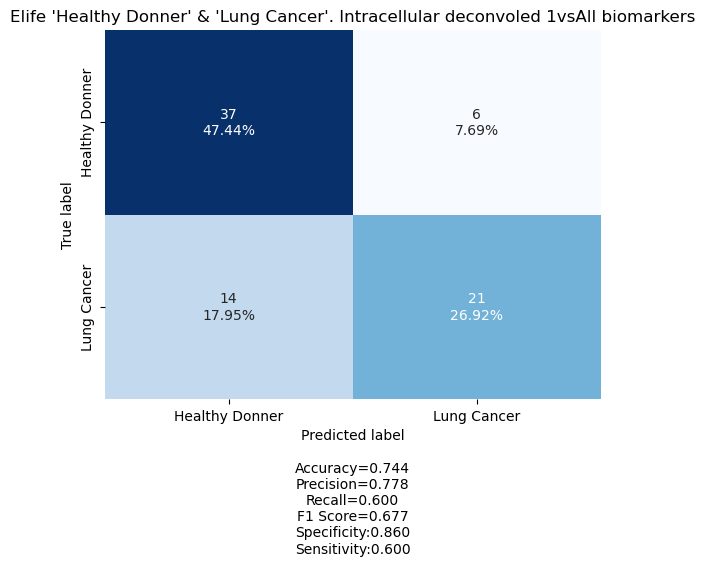

In [17]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = [ 'Healthy Donner', 'Lung Cancer',]
title = "Elife 'Healthy Donner' & 'Lung Cancer'. Intracellular deconvoled 1vsAll biomarkers"
# todo we may want to switch to # https://scikit-plot.readthedocs.io/en/stable/metrics.html
fig,panel = make_confusion_matrix(confusionMatrixData, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [18]:
imgFilePath = imgOut + "/trainingConfusionMatrix.png"
print(imgFilePath)
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)

/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/img/trainingConfusionMatrix.png


/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/img/trainingConfusionMatrix.png
saving:
/private/groups/kimlab/aedavids/elife/testIntracellularLungCancerBiomarkersOnExtracellularSamples.out/img/trainingROC.png


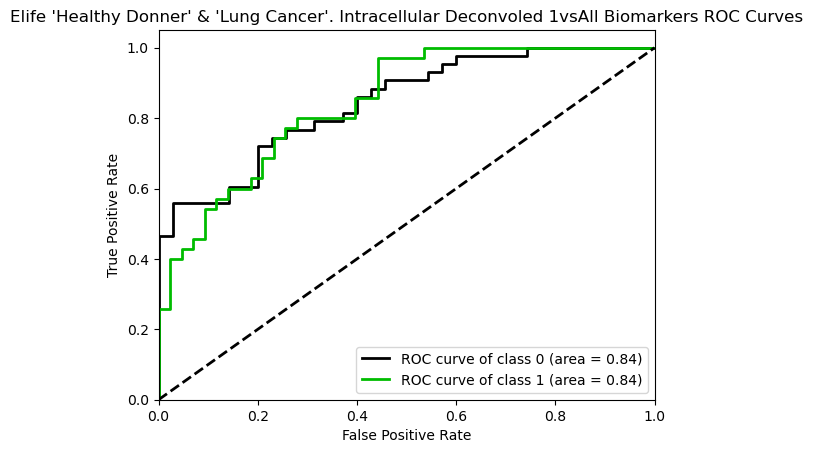

In [19]:
def plotROC():
    # https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc
    yProbability = lrModel.predict_proba(XScaled)
    rocPanel = skplt.metrics.plot_roc(y, yProbability,
                          title="Elife 'Healthy Donner' & 'Lung Cancer'. Intracellular Deconvoled 1vsAll Biomarkers ROC Curves",
                                      plot_micro=False,
                                      plot_macro=False,
                          )
    imgRocFilePath = imgOut + "/trainingROC.png"
    print(imgFilePath)
    fig =rocPanel.get_figure()
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saving:\n{imgRocFilePath}')

plotROC()

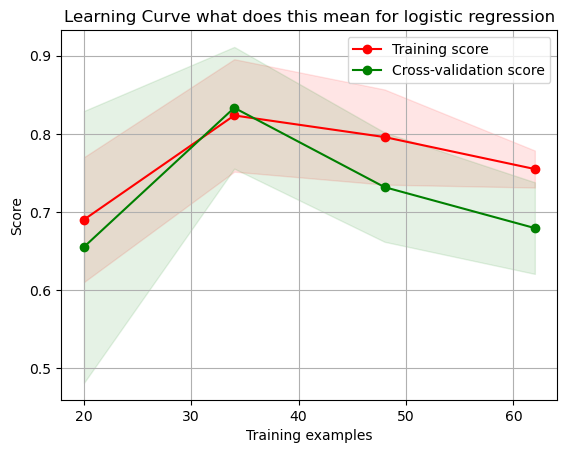

In [20]:
# https://scikit-plot.readthedocs.io/en/stable/estimators.html#module-scikitplot.estimators
# AEDWIP todo do we pass y or yHat?
learningCurvePanel = skplt.estimators.plot_learning_curve(lrModel, XScaled, yHat,
                                     title="Learning Curve what does this mean for logistic regression")

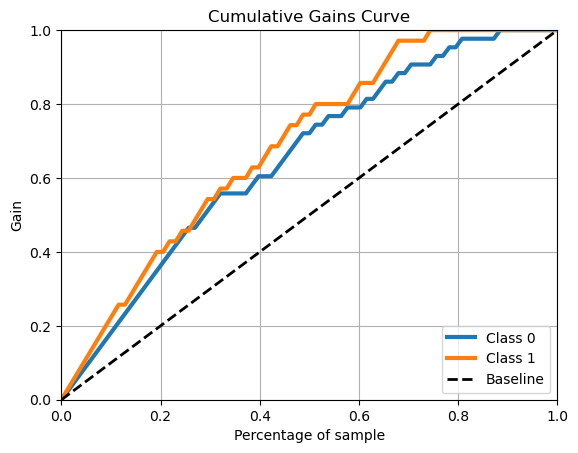

In [21]:
# https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_cumulative_gain
# http://mlwiki.org/index.php/Cumulative_Gain_Chart.
yProbability = lrModel.predict_proba(XScaled)
cumlativeGainPanel = skplt.metrics.plot_cumulative_gain(y, yProbability)

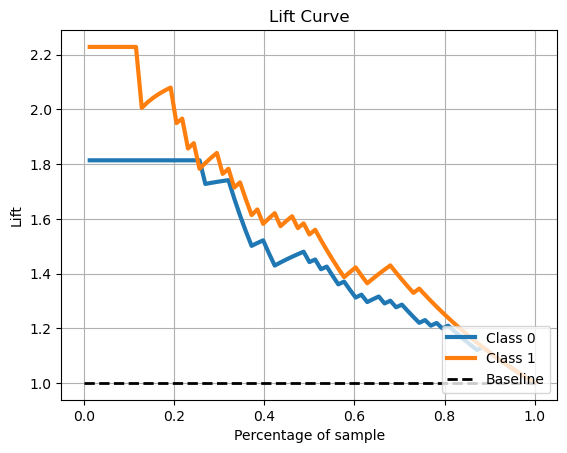

In [22]:
# https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_lift_curve
# http://mlwiki.org/index.php/Cumulative_Gain_Chart.
yProbability = lrModel.predict_proba(XScaled)
liftCurvePanel = skplt.metrics.plot_lift_curve(y, yProbability)